In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

Сделаем красивую визуализацию данных: гистограммы распределений по классам и боксплоты.


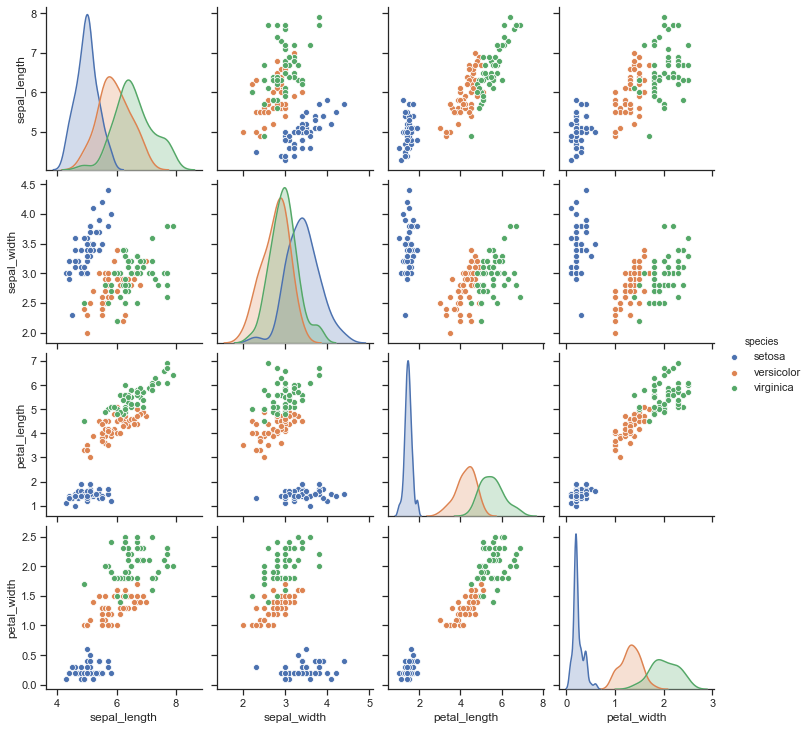

In [2]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
iris = sns.load_dataset("iris")
g = sns.pairplot(iris, hue="species")

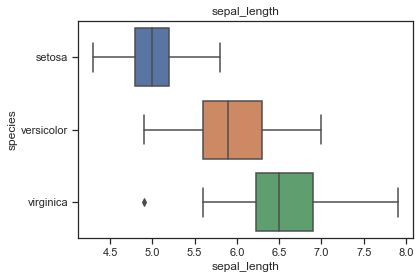

In [18]:
import matplotlib.pyplot as plt

sns.boxplot(data=iris, x='sepal_length', y='species' )
_ = plt.title('sepal_length')

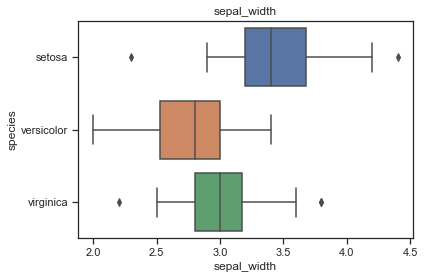

In [19]:
sns.boxplot(data=iris, x='sepal_width', y='species' )
_ = plt.title('sepal_width')

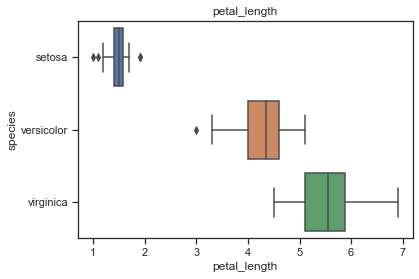

In [20]:
sns.boxplot(data=iris, x='petal_length', y='species' )
_ = plt.title('petal_length')

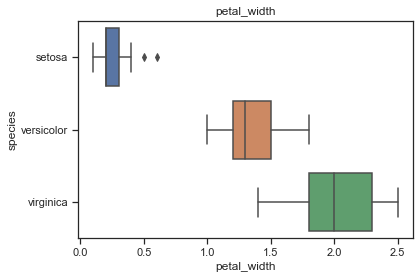

In [21]:
sns.boxplot(data=iris, x='petal_width', y='species' )
_ = plt.title('petal_width')

In [3]:
data = load_iris()
class1 = data.data[data.target == 0]
class2 = data.data[data.target == 1]
class3 = data.data[data.target == 2]

Произведем однофакторный дисперсионный анализ для проверки гипотезы о равестве средних:

In [38]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

for name in iris.columns[:-1]:
    lm = ols(formula=name+' ~ species' ,data=iris).fit()
    table = sm.stats.anova_lm(lm)
    print("{}\n\n".format(table))

             df     sum_sq    mean_sq           F        PR(>F)
species     2.0  63.212133  31.606067  119.264502  1.669669e-31
Residual  147.0  38.956200   0.265008         NaN           NaN


             df     sum_sq   mean_sq         F        PR(>F)
species     2.0  11.344933  5.672467  49.16004  4.492017e-17
Residual  147.0  16.962000  0.115388       NaN           NaN


             df    sum_sq     mean_sq            F        PR(>F)
species     2.0  437.1028  218.551400  1180.161182  2.856777e-91
Residual  147.0   27.2226    0.185188          NaN           NaN


             df     sum_sq    mean_sq           F        PR(>F)
species     2.0  80.413333  40.206667  960.007147  4.169446e-85
Residual  147.0   6.156600   0.041882         NaN           NaN




Далее нужно определить размер эффекта. Для начала проверим, являются ли распределения признаков по классам независимыми и нормальными.

In [4]:
import scipy.stats as st

def ttest(data1, data2):
    n = data1.shape[0]
    pearson = st.pearsonr(data1, data2)[0]
    if pearson == 1.:
        pearson = 0.99999
        
    T = pearson*np.sqrt(n-2)/np.sqrt(1-pearson**2)
    t_pval = 2 *(1 - st.distributions.t(n-2).cdf(abs(T)))
    return t_pval 

In [7]:
for i in range(4):
    feature = iris.columns[i]
    print("{} (class 1 and 2): {}".format(feature, ttest(class1[:, i], class2[:, i])))
    print("{} (class 1 and 3): {}".format(feature, ttest(class1[:, i], class3[:, i])))
    print("{} (class 2 and 3): {} \n{}".format(feature, ttest(class2[:, i], class3[:, i]), '-'*30))

sepal_length (class 1 and 2): 0.5767425210865991
sepal_length (class 1 and 3): 0.3529132674490505
sepal_length (class 2 and 3): 0.3264185287746799 
------------------------------
sepal_width (class 1 and 2): 0.31919246514246113
sepal_width (class 1 and 3): 0.9665925671071878
sepal_width (class 2 and 3): 0.5502443700407316 
------------------------------
petal_length (class 1 and 2): 0.18264303240686508
petal_length (class 1 and 3): 0.48111608708369236
petal_length (class 2 and 3): 0.5442144152104995 
------------------------------
petal_width (class 1 and 2): 0.2212886397895506
petal_width (class 1 and 3): 0.5917222695167106
petal_width (class 2 and 3): 0.9459022225187168 
------------------------------


Как видим, достигаемые уровни значисмости для t-критерия Стьюдента довольно высокие, и можно говорить о независимости признаков для различных классов.

Проверим, принадлежат ли данные нормальному распределению. Получается, что условию нормальности не удовлетворяют только распределения признака 'petal_width', поэтому для этой группы выберем способ подсчета размера эффекта, отличный от остальных групп.

In [50]:
from scipy.stats import shapiro

for name in iris.columns[:-1]:
    print(name)
    for species in set(iris['species']):
        print('{}: {}'.format(species, shapiro(iris[iris['species'] == species][name])))
    print('-'*30)

sepal_length
versicolor: (0.9778355956077576, 0.46473264694213867)
virginica: (0.9711798429489136, 0.25832483172416687)
setosa: (0.9776989221572876, 0.4595281183719635)
------------------------------
sepal_width
versicolor: (0.9741330742835999, 0.33798879384994507)
virginica: (0.9673910140991211, 0.1809043288230896)
setosa: (0.97171950340271, 0.2715264856815338)
------------------------------
petal_length
versicolor: (0.9660047888755798, 0.1584833413362503)
virginica: (0.9621862769126892, 0.10977369546890259)
setosa: (0.9549766182899475, 0.05481043830513954)
------------------------------
petal_width
versicolor: (0.947626531124115, 0.027278218418359756)
virginica: (0.9597718715667725, 0.08695744723081589)
setosa: (0.7997642159461975, 8.65842082475865e-07)
------------------------------


Проверим существенность различий между группами для трех первых признаков методом HSD Tukey:

In [48]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

for name in iris.columns[:-2]:
    mc = MultiComparison(iris[name], iris['species'])
    result = mc.tukeyhsd()
    print("{}\n\n".format(result))

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1     group2   meandiff p-adj lower  upper  reject
---------------------------------------------------------
    setosa versicolor     0.93 0.001 0.6862 1.1738   True
    setosa  virginica    1.582 0.001 1.3382 1.8258   True
versicolor  virginica    0.652 0.001 0.4082 0.8958   True
---------------------------------------------------------


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    setosa versicolor   -0.658  0.001 -0.8189 -0.4971   True
    setosa  virginica   -0.454  0.001 -0.6149 -0.2931   True
versicolor  virginica    0.204 0.0088  0.0431  0.3649   True
------------------------------------------------------------


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1     group2   meandiff p-adj lower  upper  reject
-----------------------------------------------

Также в силу проверенной независимости можем рассчитать размер эффекта Cohen d и 95% доверительные интервалы для него для всех четырех признаков:

In [52]:
from numpy.random import randn
from numpy.random import seed
from numpy import mean
from numpy import var
from math import sqrt
 
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = mean(d1), mean(d2)
    d = (u1 - u2) / s
    # calculate the confidence interval
    sigma = 1.96 * np.sqrt((n1 + n2)/(n1 * n2) + d**2 / (n1 + n2))
    return round(d, 2), (round(d-sigma, 4), round(d+sigma, 4))


In [53]:
for i in range(4):
    feature = iris.columns[i]
    print("{} (class 1 and 2): {}".format(feature, cohend(class1[:, i], class2[:, i])))
    print("{} (class 1 and 3): {}".format(feature, cohend(class1[:, i], class3[:, i])))
    print("{} (class 2 and 3): {} \n{}".format(feature, cohend(class2[:, i], class3[:, i]), '-'*30))

sepal_length (class 1 and 2): (-2.1, (-2.6732, -1.5352))
sepal_length (class 1 and 3): (-3.08, (-3.7966, -2.3579))
sepal_length (class 2 and 3): (-1.13, (-1.5757, -0.676)) 
------------------------------
sepal_width (class 1 and 2): (1.89, (1.3515, 2.4305))
sepal_width (class 1 and 3): (1.29, (0.8236, 1.7565))
sepal_width (class 2 and 3): (-0.64, (-1.0528, -0.2295)) 
------------------------------
petal_length (class 1 and 2): (-7.9, (-9.4955, -6.3016))
petal_length (class 1 and 3): (-10.0, (-11.9955, -7.999))
petal_length (class 2 and 3): (-2.52, (-3.1514, -1.8901)) 
------------------------------
petal_width (class 1 and 2): (-6.82, (-8.2083, -5.4238))
petal_width (class 1 and 3): (-8.56, (-10.2796, -6.8348))
petal_width (class 2 and 3): (-2.93, (-3.6196, -2.2306)) 
------------------------------


Таким образом, каждая из характеристик отличается между разными классами, и исходя из размера эффекта, различие между средними ширины наружной доли околоцветника наименее вырожено, в то время как параметры внутренней доли околоцветника в среднем различаются гораздо сильнее.